<a href="https://colab.research.google.com/github/hamedmirsadeghi/binary_classification/blob/main/Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification (Job Recommendation)

# Overview

In this notebook, a job remmomendation system is build using various binary classification techniques.

[Getting Started](#Getting_Started)

[Dataset](#Dataset)

[Data Distributions](#Data_Distributions)

[Encodings](#Encodings)

[Imputing](#Imputing)

[Resampling](#Resampling)

[Metrics](#Metrics)

[Modeling](#Modeling)

[Conclusion](#Conclusion)

<a name="Getting_Started"></a>

# Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [3]:
%%capture
!pip install category_encoders
!pip install tensorflow-addons

In [4]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as random
import category_encoders as ce
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow_addons.metrics import F1Score
from keras.metrics import *
from keras.optimizers import Adam
import xgboost as xgb
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc, roc_auc_score, roc_curve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [10, 3]  # width, height
plt.rcParams['xtick.direction'] = 'out'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


<a name="Dataset"></a>
# Dataset
Here the dataset is imported and briefly explored.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
ref_directory = '/content/drive/MyDrive/technical'
os.chdir(ref_directory)
print('list of files:')
print(os.listdir(ref_directory))
print('='*100)

print('Uploading the .csv file >>>>>>>>>>>>>>>>>')
dataset_path = './dataset.csv'
df = pd.read_csv(dataset_path , sep='\t' )
print('='*100)

print('Dataset info:')
print(' ')
print("dataframe shape: " , df.shape)
print(' ')
df.info()

print('='* 100)
print(' ')
print('percentage of missing values in each column:')
null_percentage = df.isnull().sum() * 100 / len(df)
print(null_percentage)

print('='* 100)
print('number of distinct values per column:')
print(' ')
print(df.nunique())
print('='*100)
df.head()

list of files:
['dataset.csv', 'README.txt', 'Binary_Classification.ipynb']
Uploading the .csv file >>>>>>>>>>>>>>>>>
Dataset info:
 
dataframe shape:  (200000, 8)
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   is_executive                   200000 non-null  int64  
 1   career_level                   186052 non-null  float64
 2   discipline_id                  184090 non-null  float64
 3   jobrole_id                     200000 non-null  int64  
 4   industry_id                    200000 non-null  int64  
 5   company_size                   183894 non-null  float64
 6   number_of_previous_cv_entries  200000 non-null  int64  
 7   will_be_executive              200000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 12.2 MB
 
percentage of missing values in each column:
is_executive    

,is_executive,career_level,discipline_id,jobrole_id,industry_id,company_size,number_of_previous_cv_entries,will_be_executive
0,0,NaN,NaN,6116,40000,NaN,10,0
1,0,3.0,1002.0,5043,230000,0.0,5,0
2,0,3.0,0.0,7169,130000,7.0,3,0
3,0,0.0,1003.0,5426,90000,0.0,3,0
4,1,5.0,0.0,6730,220000,9.0,5,0


So the dataframe has `8` columns out of which `3` of them has `<10%` `NaN` values in them. 

Most of the features are categorical;

`['is_executive', 'career_level', 'discipline_id', 'industry_id']`

out of which `'career_level'` is `ordinal` and the rest are `nominal`.

From the instruction file, it was not clear whether values in `'jobrole_id'`
have ordinal meaning or not. I tried setting it both to `numerical` but it did not help my models, so I treated it as `categorical` variable and encoded it into some dummy features.

Apart from the `NaN` values, based on the Readme file, unknown values in `['career_level', 'industry_id', 'company_size']` are filled with `0`. So I will replace all `NaN` values in the dataframe with `0` to make the dataframe consistant.



In [ ]:
# fill the NA values with 0 to be consistent: 
df = df.fillna(0)

<a name="Data_Distributions"></a>

# Data Distributions:

The following are the bar plot of the values in each column to get an idea of their data distributions. 

Looking at the target `'will_be_executive'` plot we can see the data is imbalanced. So either used some up/down sampling techniques (like `SMOTE`) to balance the two classes in the target column or use some sort of uneven weights for `cost/loss` functions to put more emphasis on less frequent class. 

The other observation is the huge number of rows with `0` (i.e. `'unknown'`) values in `['career_level', 'discipline_id', 'company_size']`. Since `30-60%` of these features are `unknown`, some imputation technique are tried to fill the missing values.

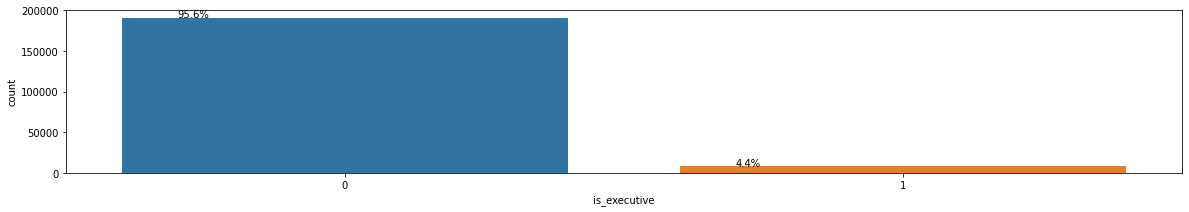

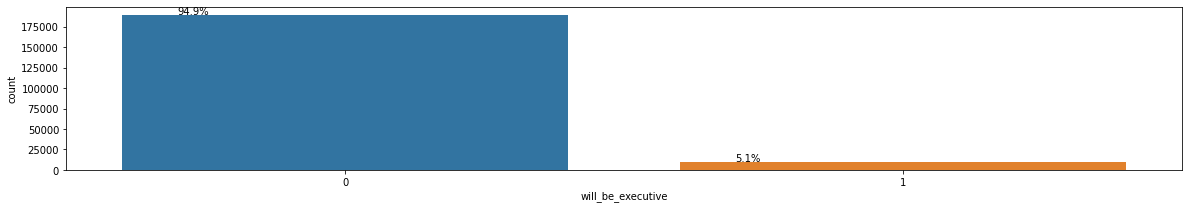

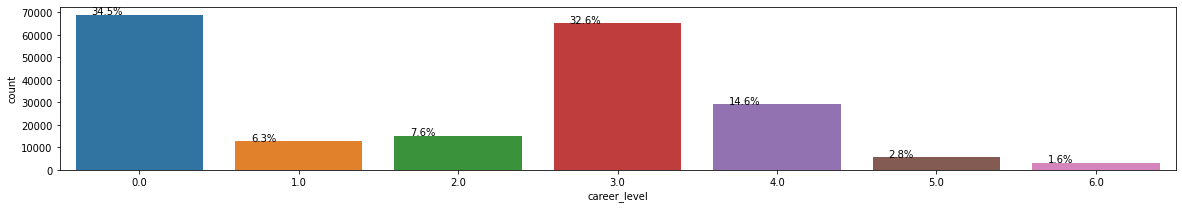

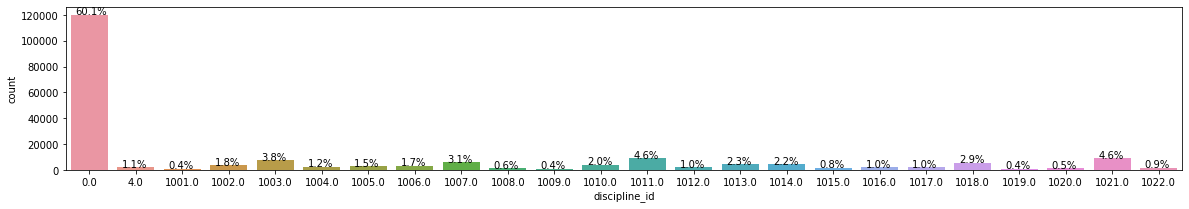

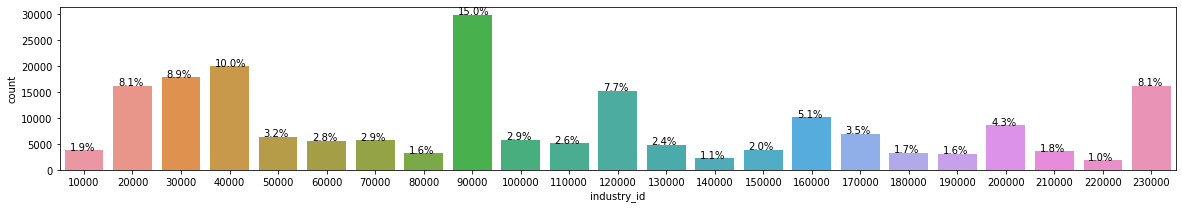

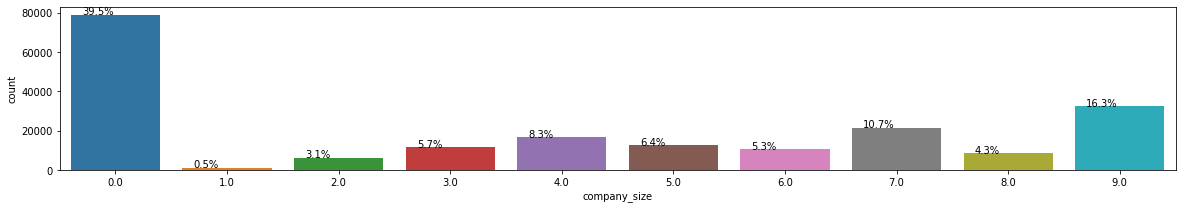

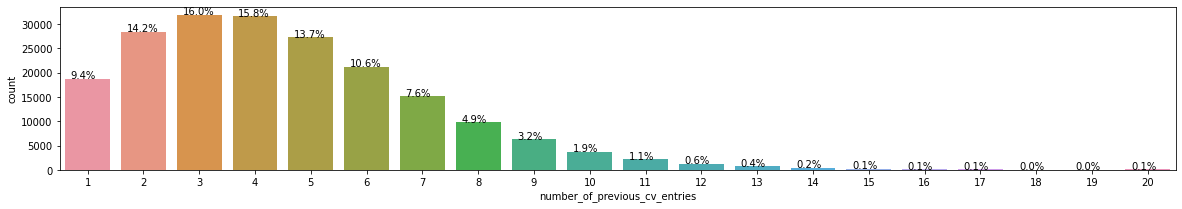

In [ ]:

for name in ["is_executive","will_be_executive", "career_level", "discipline_id", "industry_id", 'company_size', 'number_of_previous_cv_entries' ]:

    plt.rcParams["figure.figsize"] = [20, 3]  # width, height
    ax = sns.countplot(x=name, data=df, )
    total = len(df)*1.
    for p in ax.patches:
            ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
    plt.show()
    print('='* 150)

Before resampling/encoding data, I replaced all the `0` values with `np.nan` as they are `unknown`. Later on, they will be imputed.

In [ ]:
df = df.astype({"is_executive":'category', 
                "career_level":'int64', 
                "discipline_id":'category', 
                "jobrole_id":'int64', 
                'industry_id':'category', 
                'company_size':'int64', 
                'number_of_previous_cv_entries':'int64', 
                'will_be_executive':'category'})

print('='* 100)
for name in ['career_level', 'discipline_id', 'jobrole_id', 'industry_id', 'company_size']:
    print('replacing 0 with np.nan in >>>>> ', name)
    df.loc[df[name]==0,name] = np.nan

print('='* 100)
print(' ')
print('percentage of unknown/missing values in each column:')
null_percentage = df.isnull().sum() * 100 / len(df)
print(null_percentage)

print('='* 100)
print(' ')
print('shape of the dataframe if we drop rows containing np.nan :')    
print( df.dropna().shape )

replacing 0 with np.nan in >>>>>  career_level
replacing 0 with np.nan in >>>>>  discipline_id
replacing 0 with np.nan in >>>>>  jobrole_id
replacing 0 with np.nan in >>>>>  industry_id
replacing 0 with np.nan in >>>>>  company_size
 
percentage of unknown/missing values in each column:
is_executive                      0.0000
career_level                     34.5170
discipline_id                    60.1435
jobrole_id                        0.0000
industry_id                       0.0000
company_size                     39.4930
number_of_previous_cv_entries     0.0000
will_be_executive                 0.0000
dtype: float64
 
shape of the dataframe if we drop rows containing np.nan :
(47822, 8)


<a name="Encodings"></a>
# Encodings

Also to feeding the categorical variables to the models, we need to encode them.
Encoding the categorical features are done using `BinaryEncoder` from `category_encoders` libraries which , compared to `one-hot-encodding`, has the benefit of reducing the number of dummy features.

Although `'career_level'` is in fact a categorical variable, since it is ordinal I kept it as it is (integer) and did not encode it.

One important point before performing resampling/encoding is that, to prevent data leakage, the `train` and `test` rows are seperated and the resampler/encoder fit on the `train` data only then the fitted models are used to resample/encode the `test` features. `train/test` split ratio of `75/25` is used in this study although for a more comprehensive analysis `cross-validation` might be a much more robust method.

In [ ]:
# Randomly sample 75% of your dataframe for train
train = df.sample(frac=0.75, random_state=1).copy()
test = df.drop(index = train.index).copy()


def encode(train, test, columns):
    """
    INPUTS:
        train and test dataframes and the list of categorical columns to encode
        encoder fits on train dataframe and encodes both train and test
    RETURNS:
        train and test dataframes with dummy variables replacing categorical columns.
        The number of dummy variables are less than One-hot-encoding
    """ 
    #Create object for binary encoding
    encoder= ce.BinaryEncoder(cols=columns, return_df=True ,handle_unknown='return_nan')
    #Fit and Transform Data 
    train_encoded=encoder.fit_transform(train)
    test_encoded= encoder.transform(test)
    # remove the constant encoded features:
    test_encoded = test_encoded.loc[:,test_encoded.apply(pd.Series.nunique) != 1]
    train_encoded = train_encoded.loc[:,train_encoded.apply(pd.Series.nunique) != 1]
    return train_encoded, test_encoded 


train_encoded, test_encoded = encode(train, test, ['jobrole_id', 'industry_id','discipline_id'])

print('='* 150)
print(' ')
print('percentage of unknown/missing values in each column:')
null_percentage = train_encoded.isnull().sum() * 100 / len(train_encoded)
print(null_percentage)

 
percentage of unknown/missing values in each column:
is_executive                      0.000000
career_level                     34.467333
discipline_id_1                  60.152667
discipline_id_2                  60.152667
discipline_id_3                  60.152667
discipline_id_4                  60.152667
discipline_id_5                  60.152667
jobrole_id_1                      0.000000
jobrole_id_2                      0.000000
jobrole_id_3                      0.000000
jobrole_id_4                      0.000000
jobrole_id_5                      0.000000
jobrole_id_6                      0.000000
jobrole_id_7                      0.000000
jobrole_id_8                      0.000000
jobrole_id_9                      0.000000
jobrole_id_10                     0.000000
jobrole_id_11                     0.000000
industry_id_1                     0.000000
industry_id_2                     0.000000
industry_id_3                     0.000000
industry_id_4                     0.000000

In [ ]:
# Define features (X) and target(Y) dataframes for train and test:
target = 'will_be_executive'
Y_train = train_encoded[target]
X_train = train_encoded[[name for name in train_encoded.columns if name != target ]]
Y_test = test_encoded[target]
X_test = test_encoded[[name for name in test_encoded.columns if name != target ]]

<a name="Imputing"></a>
# Imputing

Various imputation technique are available in `sklearn`. The most advanced method in the data science community is `'MICE'`. `'knn'` imputer is slow as it need to find the distance to all other data points. I varied the imputation methods for this dataset and it did not have noticable effect on the model performances.

Again, to prevent data leakage, the imputers are trained on the `train` dataframe and then transformed the `test` dataframe.

In [ ]:
def Impute(X1, X2, method='mean'):
    """
    INPUTS:
        X1, X2 dataframes which have missing values and the imputation method
    RETURNS:
        X1, X2 numpy arrays imputed by the imputer
    """ 
    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
    if method == 'median':
        imp = SimpleImputer(strategy='median')
    if method == 'most_frequent':
        imp = SimpleImputer( strategy='most_frequent')
    if method == 'constant':
        imp = SimpleImputer(strategy='constant', fill_value=0)
    if method == 'mice':
        imp = IterativeImputer(random_state=0)
    if method == 'knn':
        imp = KNNImputer()
    X_1 = imp.fit_transform(X1)
    X_2 = imp.transform(X2)
    return X_1, X_2

# imputing
X_train, X_test = Impute(X_train, X_test, 'median')

<a name="Resampling"></a>
# Resampling

Since we have class imbalance, I used `SMOTE` to down sample the majority class and upsample the minority. As mentioned in a [paper](https://arxiv.org/abs/1106.1813), it is believed that `SMOTE` performs better when combined with undersampling of the majority class, such as random undersampling.
I will first oversample the minority class with `SMOTE` to about a `2:10` ratio, then undersample the majority class to achieve about a `3:10` ratio.


In [ ]:

# SMOTE Over sampling as well as random undersampling
def resample(X_train, Y_train, over_ratio = 0.2, under_ratio = 0.3, random_state = 100):
    """
    INPUTS:
        X_train, Y_train dataframes which are feature/target dataframes with
        imbalanced data
        over_ratio is the ratio of minority/majority after over sampling the minority class
        under_ratio is the ratio of minority/majority after under sampling the majority class
    RETURNS:
        X_train, Y_train numpy arrays with balanced classes
    """   
    print('initial number of rows: ', X_train.shape[0])
    over = SMOTE(sampling_strategy= over_ratio, random_state=random_state)
    X_train, Y_train = over.fit_resample(X_train, Y_train)
    print('number of rows after over sampling: ', X_train.shape[0])
    under = RandomUnderSampler(sampling_strategy=under_ratio,random_state=random_state)
    X_train, Y_train = under.fit_resample(X_train, Y_train)
    print('final number of rows after under sampling: ', X_train.shape[0])
    return X_train, Y_train

X_train, Y_train = resample(X_train, Y_train, over_ratio = 0.2, under_ratio = 0.3, random_state = 100)

initial number of rows:  150000
number of rows after over sampling:  170779
final number of rows after under sampling:  123339


One method of compensating for class imbalance (instead of resampling) is defining class weight dictionary which allows for setting larger penalties on misclassification of the minority class. Below, I showed one method of setting imbalanced weights for calculating loss function. The weights are inversely proportional with the original dataframe's counts per class. So the minority class will have more weight for wrong predictions.

In [ ]:
counts = np.bincount(df[target])
print("Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(df)))

weight_for_0 = counts[1] / len(df)
weight_for_1 = counts[0] / len(df)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

Number of positive samples in training data: 10158 (5.08% of total)
{0: 0.05079, 1: 0.94921}


For the rest of this notebook since I already tried to solve the imbalanced classes issue by resampling, I will set both class weights equal. but in theory it can be adjusted to the level that works best for our application.

In [ ]:
class_weight = {0: 0.5, 1: 0.5}
print(class_weight)

{0: 0.5, 1: 0.5}


<a name="Metrics"></a>
# Metrics

Since in the challenge description it is mentioned that senior level people might get offended by getting junior level jobs, the `False Negative rate` must be emphesised in the metric definition. Generally `F1` scores are used as a good balance between recall and precision. But here given the situation, I think `F2` along with `ROC AUC score` might be a better choice as it puts more attention on minimizing false negatives and the minority class.



In [ ]:
def metrics(Y_test, Y_pred_prob, threshold, verbose = True):
    """
    INPUTS:
        Y_test, Y_pred_prob dataframes which are target/prediction/prediction_probability
    RETURNS:
        f1,f2, roc_auc scores
    """ 
    Y_pred = (Y_pred_prob > threshold).astype('float')
    df_table = confusion_matrix( Y_test,Y_pred)
    TP =  df_table[1,1]
    TN =  df_table[0,0]
    FP =  df_table[0,1] 
    FN =  df_table[1,0] 
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    acc = (TN + TP) / (TN + FN + FP + TP)
    specificity = TN/(TN + FP)
    f1 = (2*p*r)/(p+r)
    f2 = (5*p*r)/(4*p+r)
    roc_auc = roc_auc_score(Y_test,Y_pred_prob)
    gmeans =  np.sqrt(r * specificity) #np.sqrt(tpr * (1-fpr))
    
    output = {
        'Threshold' : threshold,
        'TP' : TP,
        'FP' : FP,
        'TN' : TN,
        'FN' : FN,
        'accuracy' : acc,
        'precision': p,
        'recall': r,
        'specificity': specificity,
        'F1 score' : f1,
        'F2 score': f2,
        'GMeans': gmeans,
        'roc_auc_score': roc_auc
    }
    if verbose:
        print(output)
    return output

### Plotting Funtions

The two function below will plot `precision-recall` and `ROC` curves and return the corresponding optimal scores. They will find the optimal score while varying the threshold value (i.e. threshold that we use to convert probability to binary class labels). All main metrics are returned at the optimal threshold.

**Note that for this data set that is imbalanced and False Negative rate should be small, using `pr_curve` with `F2` score seems to be a better choice. This selection will put more emphesis on the minority class. Therefore the following modeling steps are focused on `F2` scores from `plot_pr_curve` function.**

In [ ]:
def plot_pr_curve(testy , yhat, label, score_type = 'F2'):
    """
    This function takes in target and prediction of a binary classification mode
    and plots the precision-recall curve and finds the maximum score point by
    varying the thereshold of the classification labels.
    INPUTS:
        testy , yhat numpy array which are the target for a model and its probability prediction
        label is the label of the plot
        score_type is string determining the type of score to maximize
    RETURNS:
        precision-recall curve and the optimal thereshold and the other metrics in that threshold
    """ 
    plt.rcParams["figure.figsize"] = [4, 4]  # width, height
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(testy, yhat)
    # convert to f score
    if score_type == 'F1':
        fscore = (2 * precision * recall) / (precision + recall)
    if score_type == 'F2':
        fscore = (5 * precision * recall) / (4*precision + recall)
    # locate the index of the largest f score
    # since we want large recalls, for finding the largest f-score first get rid of the small recalls.
    sub_fscore = fscore[recall > 0.2]
    ix, = np.where(fscore == np.max(sub_fscore) )[0] # integers

    #ix = np.argmax(fscore)
    # plot the roc curve for the model
    no_skill = len(testy[testy==1]) / len(testy)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label= label)
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', linewidths=4)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(' Best Threshold=%f, %s-Score=%.3f' % (thresholds[ix], score_type, fscore[ix]))
    plt.legend()
    # show the plot
    plt.show()
    print(' Best Threshold=%f, %s-Score=%.3f' % (thresholds[ix], score_type, fscore[ix]))
    output =  metrics(testy, yhat, thresholds[ix], verbose = True)
    return output

def plot_roc_curve(testy,yhat, label):
    """
    This function takes in target and prediction of a binary classification mode
    and plots the ROC curve and finds the maximum Gmeans score point by
    varying the thereshold of the classification labels.
    INPUTS:
        testy , yhat numpy array which are the target for a model and its probability prediction
        label is the label of the plot
    RETURNS:
        ROC curve and the optimal thereshold and the other metrics in that threshold
    """ 
    plt.rcParams["figure.figsize"] = [4, 4]  # width, height
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(testy, yhat)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= label)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best', linewidths=4 )
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(' Best Threshold=%f, G-Mean-Score=%.3f' % (thresholds[ix], gmeans[ix]))
    plt.legend()
    # show the plot
    plt.show()
    print( ' Best Threshold=%f, G-Mean-Score=%.3f' % (thresholds[ix], gmeans[ix]) )
    output =  metrics(testy, yhat, thresholds[ix], verbose = True)
    return output



<a name="Modeling"></a>
# Modeling

Here multiple binary classification algorithm are implemented and their scores are reported. Obviously there are huge opportunities to improve their performances by tunning hyperparameteres but here I tried to stick to default setting as the time of this challeng is limitted.

### Standardize the data using training set statistics

Before feeding the dataset into the models, I standardized them.


In [ ]:
def standarize(X_1, X_2):
    """
    INPUTS:
        X_1, X_2 numpy array which get standardized (i.e. mean = 0, std = 1)
        mean is calculated based on X_1
    RETURNS:
        X_1, X_2 standard numpy array
    """ 
    mean = np.mean(X_1, axis=0)
    X_1 -= mean
    X_2 -= mean
    std = np.std(X_1, axis=0)
    X_1 /= std
    X_2 /= std
    return X_1, X_2

X_train, X_test = standarize(X_train, X_test)

### Logistic Regression

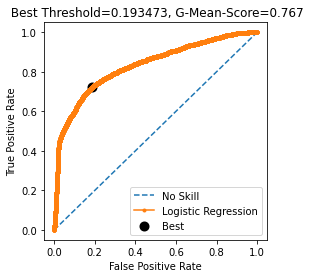

 Best Threshold=0.193473, G-Mean-Score=0.767
{'Threshold': 0.1934727213697143, 'TP': 1793, 'FP': 8945, 'TN': 38581, 'FN': 681, 'accuracy': 0.80748, 'precision': 0.16697709070590427, 'recall': 0.7247372675828617, 'specificity': 0.81178723225182, 'F1 score': 0.27141992128368153, 'F2 score': 0.43447707666957447, 'GMeans': 0.7670283310027329, 'roc_auc_score': 0.8324005035102942}


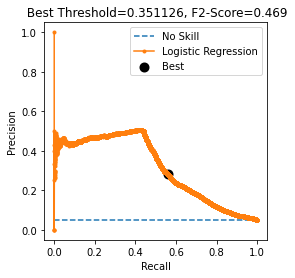

 Best Threshold=0.351126, F2-Score=0.469
{'Threshold': 0.3511258186392641, 'TP': 1381, 'FP': 3466, 'TN': 44060, 'FN': 1093, 'accuracy': 0.90882, 'precision': 0.2849185062925521, 'recall': 0.5582053354890865, 'specificity': 0.9270714977065185, 'F1 score': 0.3772708646359787, 'F2 score': 0.46835786474937263, 'GMeans': 0.7193721265100818, 'roc_auc_score': 0.8324005035102942}


In [ ]:
def logistic(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True):
    lr = LogisticRegression(class_weight=class_weight)
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_test)
    Y_pred_prob = lr.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Logistic Regression')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Logistic Regression', score_type='F2')      
    return out1, out2

lr_out1, lr_out2 = logistic(X_train,Y_train, X_test,Y_test, class_weight=class_weight)

### Naive Bayesian

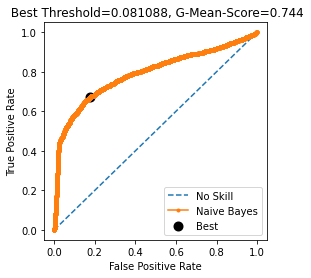

 Best Threshold=0.081088, G-Mean-Score=0.744
{'Threshold': 0.0810884033261557, 'TP': 1665, 'FP': 8470, 'TN': 39056, 'FN': 809, 'accuracy': 0.81442, 'precision': 0.16428219042920572, 'recall': 0.6729991915925626, 'specificity': 0.8217817615620924, 'F1 score': 0.26409707351891504, 'F2 score': 0.4156058109929609, 'GMeans': 0.7436790041387482, 'roc_auc_score': 0.7924030673964413}


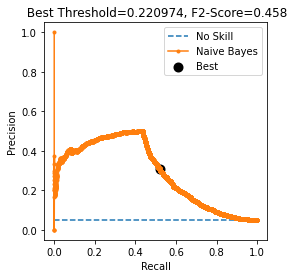

 Best Threshold=0.220974, F2-Score=0.458
{'Threshold': 0.22097376564064783, 'TP': 1286, 'FP': 2861, 'TN': 44665, 'FN': 1188, 'accuracy': 0.91902, 'precision': 0.31010368941403427, 'recall': 0.5198059822150364, 'specificity': 0.9398013718806548, 'F1 score': 0.3884609575592811, 'F2 score': 0.45787937050487787, 'GMeans': 0.6989380338752946, 'roc_auc_score': 0.7924030673964413}


In [ ]:
def NB(X_train, Y_train, X_test, Y_test, verbose = True):
    nb = GaussianNB( )
    nb.fit(X_train,Y_train)
    Y_pred = nb.predict(X_test) 
    Y_pred_prob = nb.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Naive Bayes')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Naive Bayes', score_type='F2')      
    return out1, out2

nb_out1, nb_out2 = NB(X_train,Y_train, X_test,Y_test)

### Support Vector Machine and KNN

SVM's do not naturally produce probabilities for final-predictions. These two algorithm are also very slow so I just included their code but not really run them.

In [ ]:
#from sklearn import svm

#sv = svm.SVC(kernel="rbf", C=0.025,random_state=101)
#sv.fit(X_train, Y_train)

#Y_pred = sv.predict(X_test)
#Y_pred_prob = sv.predict_proba(X_test)[:,1]
#metrics(Y_test, Y_pred,Y_pred_prob, verbose)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(X_train,Y_train)
#Y_pred=knn.predict(X_test)
#metrics(Y_test, Y_pred)

### Stochastic Gradient Descent Classifier

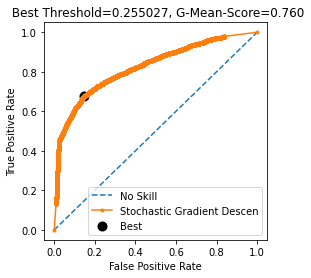

 Best Threshold=0.255027, G-Mean-Score=0.760
{'Threshold': 0.2550265353505222, 'TP': 1674, 'FP': 6944, 'TN': 40582, 'FN': 800, 'accuracy': 0.84512, 'precision': 0.19424460431654678, 'recall': 0.6766370250606305, 'specificity': 0.853890502040988, 'F1 score': 0.3018391633609809, 'F2 score': 0.4520903100356487, 'GMeans': 0.76011441837959, 'roc_auc_score': 0.8243221656896071}


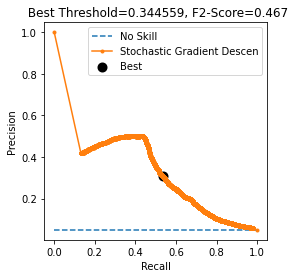

 Best Threshold=0.344559, F2-Score=0.467
{'Threshold': 0.3445590280938065, 'TP': 1322, 'FP': 2939, 'TN': 44587, 'FN': 1152, 'accuracy': 0.91818, 'precision': 0.3102558084956583, 'recall': 0.534357316087308, 'specificity': 0.9381601649623365, 'F1 score': 0.3925760950259837, 'F2 score': 0.46690683054319415, 'GMeans': 0.7080344255820477, 'roc_auc_score': 0.8243221656896071}


In [ ]:
def SGD(X_train, Y_train, X_test, Y_test , class_weight=None, verbose = True):
    sgd =  SGDClassifier(loss='modified_huber', shuffle=True,random_state=1, class_weight=class_weight, max_iter=1000, tol=1e-3)
    sgd.fit(X_train, Y_train)
    Y_pred=sgd.predict(X_test)
    Y_pred_prob = sgd.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Stochastic Gradient Descen')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Stochastic Gradient Descen', score_type='F2')      
    return out1, out2

sgd_out1, sgd_out2 = SGD(X_train, Y_train, X_test, Y_test, class_weight=class_weight)


### Random Forest

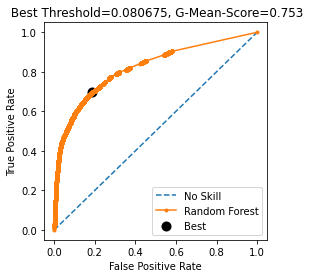

 Best Threshold=0.080675, G-Mean-Score=0.753
{'Threshold': 0.08067460317460318, 'TP': 1725, 'FP': 8924, 'TN': 38602, 'FN': 749, 'accuracy': 0.80654, 'precision': 0.16198704103671707, 'recall': 0.6972514147130153, 'specificity': 0.8122290956529058, 'F1 score': 0.26289720338337275, 'F2 score': 0.4198101727914334, 'GMeans': 0.7525475971757943, 'roc_auc_score': 0.820087973120172}


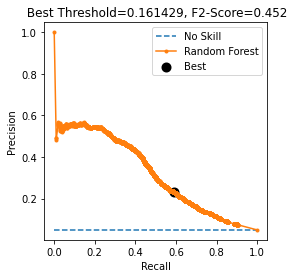

 Best Threshold=0.161429, F2-Score=0.452
{'Threshold': 0.16142857142857142, 'TP': 1461, 'FP': 4831, 'TN': 42695, 'FN': 1013, 'accuracy': 0.88312, 'precision': 0.23219961856325494, 'recall': 0.5905416329830234, 'specificity': 0.8983503766359466, 'F1 score': 0.3333333333333333, 'F2 score': 0.45126019273535944, 'GMeans': 0.7283634384079873, 'roc_auc_score': 0.820087973120172}


In [ ]:
def RF(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True):
    rf = RandomForestClassifier(random_state=1, class_weight=class_weight)
    rf.fit(X_train,Y_train)
    Y_pred = rf.predict(X_test)
    Y_pred_prob = rf.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Random Forest')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Random Forest', score_type='F2')      
    return out1, out2

rf_out1, rf_out2 = RF(X_train, Y_train, X_test, Y_test, class_weight=class_weight) 

### XGBoost

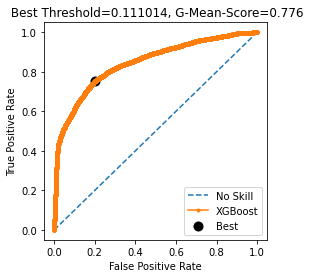

 Best Threshold=0.111014, G-Mean-Score=0.776
{'Threshold': 0.11101418, 'TP': 1860, 'FP': 9443, 'TN': 38083, 'FN': 614, 'accuracy': 0.79886, 'precision': 0.16455808192515262, 'recall': 0.751818916734034, 'specificity': 0.8013087573117872, 'F1 score': 0.2700152427959643, 'F2 score': 0.43869993867635265, 'GMeans': 0.7761694930178864, 'roc_auc_score': 0.8461397473249634}


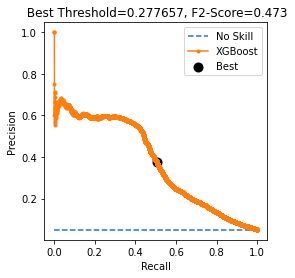

 Best Threshold=0.277657, F2-Score=0.473
{'Threshold': 0.27765658, 'TP': 1254, 'FP': 2103, 'TN': 45423, 'FN': 1220, 'accuracy': 0.93354, 'precision': 0.3735478105451296, 'recall': 0.5068714632174616, 'specificity': 0.9557505365484156, 'F1 score': 0.4301149031040988, 'F2 score': 0.4731004300913, 'GMeans': 0.696019161324722, 'roc_auc_score': 0.8461397473249634}


In [ ]:
def XGB(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True):
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, scale_pos_weight=class_weight[1]/class_weight[0] )
    xgb_model.fit(X_train, Y_train) 
    Y_pred = xgb_model.predict(X_test)
    Y_pred_prob = xgb_model.predict_proba(X_test)[:,1]
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'XGBoost')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'XGBoost', score_type='F2')      
    return out1, out2

xgb_out1, xgb_out2 = XGB(X_train, Y_train, X_test, Y_test, class_weight=class_weight)

### Neural Networks

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


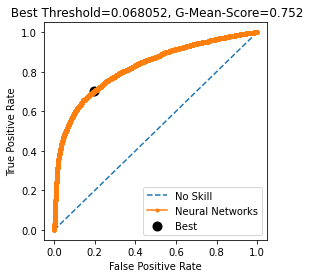

 Best Threshold=0.068052, G-Mean-Score=0.752
{'Threshold': 0.06805241, 'TP': 1736, 'FP': 9270, 'TN': 38256, 'FN': 738, 'accuracy': 0.79984, 'precision': 0.1577321461021261, 'recall': 0.7016976556184317, 'specificity': 0.8049488700921601, 'F1 score': 0.257566765578635, 'F2 score': 0.4152712659075687, 'GMeans': 0.7515522171056208, 'roc_auc_score': 0.8244697639186971}


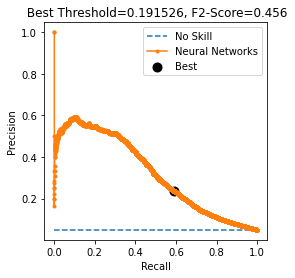

 Best Threshold=0.191526, F2-Score=0.456
{'Threshold': 0.1915259, 'TP': 1464, 'FP': 4699, 'TN': 42827, 'FN': 1010, 'accuracy': 0.88582, 'precision': 0.23754664935907838, 'recall': 0.5917542441390461, 'specificity': 0.9011278037284854, 'F1 score': 0.33900659951372003, 'F2 score': 0.45581916682234264, 'GMeans': 0.7302370864096321, 'roc_auc_score': 0.8244697639186971}


In [ ]:
def NN(X_train, Y_train, X_test, Y_test, class_weight=None, verbose = True, learningR= 1e-2, epochs= 40, batch_size=256, plot =False):
    model = Sequential()
    model.add(Dense(256,activation='relu',input_dim= X_train.shape[1]))
    #model.add(Dense(128,activation='relu') )
    #model.add( Dropout(0.3))
    #model.add( BatchNormalization())
    model.add(Dense(32,activation='relu') )
    #model.add( Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))

    mtrcs = [
    #    FalseNegatives(name="fn"),
    #    FalsePositives(name="fp"),
    #    TrueNegatives(name="tn"),
    #    TruePositives(name="tp"),
    #    Precision(name="precision"),
        Recall(name="recall"),
    #    'accuracy', 
        F1Score(num_classes=1, threshold=0.5)
    ]

    model.compile(loss='binary_crossentropy',optimizer=Adam(learningR),metrics=mtrcs)
    history = model.fit(X_train,Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size,class_weight=class_weight, verbose = 0)
    Y_pred_prob = model.predict(X_test)
    Y_pred = [round(x[0]) for x in Y_pred_prob]
    if plot:
        # plot training history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    if verbose:
        out1 = plot_roc_curve(Y_test, Y_pred_prob, label = 'Neural Networks')
        out2 = plot_pr_curve(Y_test, Y_pred_prob, label = 'Neural Networks', score_type='F2')      
    return out1, out2

nn_out1, nn_out2 = NN(X_train, Y_train, X_test,Y_test, class_weight=class_weight)


<a name="Conclusion"></a>
# Conclusion

The following is the summary of the metrics for all models. Looking at the plots, `Logistic Regression` model seems to be an light and fast option given the fact that it relatively perfomes well (`F2` and `roc_auc_score` scores) and it is very fast. 

Obviously the more sofisticate models like `Neural Network` and `XGBoost` are performing better even without any hyperparameter tuning. It is expected that their performance improve quite a bit with hyperparameter tuning.

One other aspect is changing imputating, encoding and resampling functions to improve results. Based on few trials that I did, imputation did not have huge influence but encoding (`discipline_id` for example) and resampling had bigger impact on the scores. There is certainly place for more investigations on encoding/resampling.

The other important factor is selecting/defining a good metric for our application. Here I tried to give more emphesis to `False Negatives` by using `F2` along with `roc_auc_score` scores. But there can be other customised metric as well as threshold selection process that fits better for this dataset and its specific application. 



In [ ]:
metric_df = pd.DataFrame(lr_out2, index=[0])
for dict1 in [nb_out2, sgd_out2, rf_out2, xgb_out2, nn_out2]:
    temp = pd.DataFrame( dict1, index=[0]) 
    metric_df = metric_df.append(temp)

metric_df.index = ['lr', 'nb', 'sgd', 'rf', 'xgb', 'nn']
metric_df

,Threshold,TP,FP,TN,FN,accuracy,precision,recall,specificity,F1 score,F2 score,GMeans,roc_auc_score
lr,0.351126,1381,3466,44060,1093,0.90882,0.284919,0.558205,0.927071,0.377271,0.468358,0.719372,0.832401
nb,0.220974,1286,2861,44665,1188,0.91902,0.310104,0.519806,0.939801,0.388461,0.457879,0.698938,0.792403
sgd,0.344559,1322,2939,44587,1152,0.91818,0.310256,0.534357,0.938160,0.392576,0.466907,0.708034,0.824322
rf,0.161429,1461,4831,42695,1013,0.88312,0.232200,0.590542,0.898350,0.333333,0.451260,0.728363,0.820088
xgb,0.277657,1254,2103,45423,1220,0.93354,0.373548,0.506871,0.955751,0.430115,0.473100,0.696019,0.846140
nn,0.191526,1464,4699,42827,1010,0.88582,0.237547,0.591754,0.901128,0.339007,0.455819,0.730237,0.824470


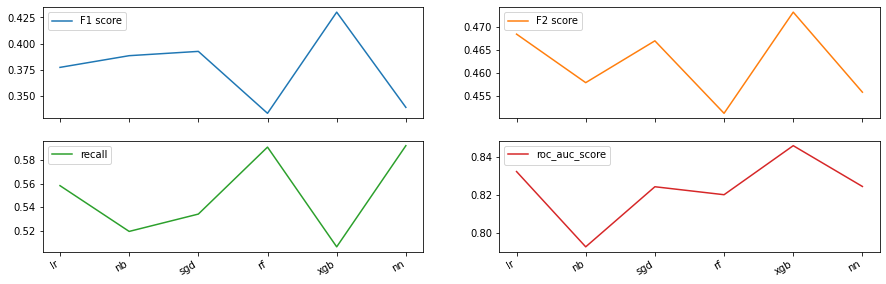

In [ ]:
metric_df[['F1 score',	'F2 score',	'recall',	'roc_auc_score']].plot( subplots= True, layout= (2,2), figsize=(15,5) );